## Encoders（エンコーダー）

すべてのエンコーダーが持つべき重要な特性がいくつかあります。

- 意味的類似性：類似した入力は高いオーバーラップを持っている必要があります。 
- 安定性：エンコード中に入力の表現が変化しないこと。
- 分散性：出力SDR は、 すべての入力に対して同じ疎分散度を持ち、ノイズとサブサンプリングを処理するのに十分なアクティブビットを持つ必要があ り ます。

エンコーダーの主なクラスは以下のとおりです。

- ScalarEncoder - スカラエンコーダー
- RDSE - ランダム分散スカラーエンコーダ (RDSE)
- DateEncoder - 日付エンコーダー

NuPICからの変更点として、カテゴリークラスはなくなり、ScalarEncoder もしくは RDSE クラスのメソッドで category を指定するようになりました。

In [7]:
!python3 -m pydoc htm.bindings.encoders. ScalarEncoderParameters

Help on module htm.bindings.encoders in htm.bindings.encoders:

NNAAMMEE
    htm.bindings.encoders - Encoders convert values into sparse distributed representation.

DDEESSCCRRIIPPTTIIOONN
    There are several critical properties which all encoders must have:
    
        1) Semantic similarity:  Similar inputs should have high overlap.  Overlap
        decreases smoothly as inputs become less similar.  Dissimilar inputs have
        very low overlap so that the output representations are not easily confused.
    
        2) Stability:  The representation for an input does not change during the
        lifetime of the encoder.
    
        3) Sparsity: The output SDR should have a similar sparsity for all inputs and
        have enough active bits to handle noise and subsampling.
    
    Reference: https://arxiv.org/pdf/1602.05925.pdf
    
    
    CategoryEncoders:
    
        To encode categories of input, make a ScalarEncoder or a Random Distributed
    Scalar Enco

In [1]:
import numpy as np

### ScalarEncoder（スカラーエンコーダー）

ScalarEncoder は数値（浮動小数点）をビットの配列にエンコードします。出力は1の連続するブロックを除いて0です。この連続ブロックの位置は入力値によって連続的に変化します。

エンコーダは内部的に使用するパラメータ構造が含まれており、すべてのフィールドは自動的に入力されます。

In [2]:
from htm.bindings.encoders import ScalarEncoder, ScalarEncoderParameters
from htm.bindings.sdr import SDR

**パラメータ**

- activeBits - エンコードされた出力 SDR の真のビット数です。
- category - 入力が列挙されたカテゴリであることを意味します。true の場合、このエンコーダは符号なし整数のみをエンコードし、すべての入力は一意で重複しない表現になります。
- clipInput - これは、入力値を [最小値、最大値] の範囲外の値を許可するかどうかを決定します。trueの場合、入力は範囲[最小値、最大値]にクリップされます。
- maximum - 入力信号の範囲を定義します。これらのエンドポイントは包括的です。
- minimum - 入力信号の範囲を定義します。これらのエンドポイントは包括的です。
- periodic - これは、入力範囲のエッジ付近で何が起こるかを制御します。 true の場合、入力値の最小値と最大値は隣接し、出力 SDR の最初のビットと最後のビットも隣接します。 1 の連続したブロックは、末尾から先頭へと回り込みます。
- radius - 半径以上で区切られた2つの入力は、重複しない表現になります。
- resolution - 解像度以上で区切られた2つの入力は、異なる表現を持つことが保証されています
- size - エンコードされた出力 SDR の総ビット数です。
- sparsity - これはアクティブビット数を指定する別の方法です。sparsityの場合はサイズも指定する必要があります。activeBitsかsparsityのどちらか一方のみを指定してください。

In [3]:
scalarEncoderParams = ScalarEncoderParameters()
scalarEncoderParams.minimum = 2.5
scalarEncoderParams.maximum = 97.5
scalarEncoderParams.activeBits = 3
scalarEncoderParams.size = 24
scalarEncoderParams.clipInput  = True

enc = ScalarEncoder(scalarEncoderParams)

print ("3 =", enc.encode(3))
print ("4 =", enc.encode(4))
print ("5 =", enc.encode(5))

3 = SDR( 24 ) 0, 1, 2
4 = SDR( 24 ) 0, 1, 2
5 = SDR( 24 ) 1, 2, 3


In [4]:
print ("3 =", enc.encode(3).dense)
print ("4 =", enc.encode(4).dense)
print ("5 =", enc.encode(5).dense)

3 = [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4 = [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5 = [0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


[[1 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 1]]


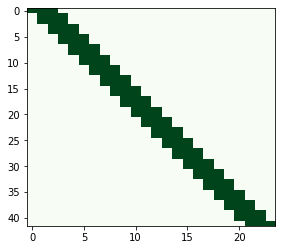

In [7]:
n_samples = (enc.parameters.maximum - enc.parameters.minimum) / enc.parameters.resolution
# エイリアシング（折り返し雑音）やアーチファクト（ノイズ）を避けるために、必要以上に多くのサンプルを使用します。
oversample = 2 
n_samples  = int(round( oversample * n_samples ))

sdrs = []
for i in np.linspace(enc.parameters.minimum, enc.parameters.maximum, n_samples):
  sdrs.append( enc.encode( i ).dense )

print(np.array(sdrs))

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(np.array(sdrs), cmap = "Greens", aspect=0.5)
plt.show()

In [8]:
# maxmumをエンコードします。
print ("100  =", enc.encode(100))

# より大きな数値が同じエンコーディングを取得することを確認してください。
print ("1000 =", enc.encode(1000))

100  = SDR( 24 ) 21, 22, 23
1000 = SDR( 24 ) 21, 22, 23


### RandomDistributedScalarEncoder（ランダム分散スカラーエンコーダー）

ランダム分散スカラーエンコーダ（RDSE）は、数値スカラー（浮動小数点）値をSDRにエンコードします。 RDSE は ScalarEncoder よりも柔軟性があります。

このエンコーダは、入力範囲の最小値と最大値を知る必要がありません。

これは、構築時に input->output マッピングを割り当てません。 その代わり、エンコーディングは実行時に決定されます。

これにより、以前のエンコーディングと競合しないランダムなアクティブビットのセットを保証することができました。

また、エンコーダは SDR を作成した可能性の高い入力値にデコードすることができます。
このRDSEは、入力とアクティブビット間の関連付けを保存しません。 この方が高速で、使用するメモリも少なくて済みます。

In [9]:
from htm.bindings.encoders import RDSE, RDSE_Parameters
from htm.bindings.sdr import SDR

**パラメータ**

- activeBits - エンコードされた出力 SDR の真のビット数です。
- category - 入力が列挙されたカテゴリであることを意味します。true の場合、このエンコーダは符号なし整数のみをエンコードし、すべての入力は一意で重複しない表現になります。
- radius - 半径以上で区切られた2つの入力は、重複しない表現になります。
- resolution - 解像度以上で区切られた2つの入力は、異なる表現を持つことが保証されています。
- seed - 入力と他のすべてのパラメータが同じであっても、異なるエンコーダが異なる出力を生成することを強制します。 同じシード、パラメータ、入力を持つ 2 つのエンコーダは、同じ出力を生成します。
- size - エンコードされた出力 SDR の総ビット数です。
- sparsity - これはアクティブビット数を指定する別の方法です。sparsityの場合はサイズも指定する必要があります。activeBitsかsparsityのどちらか一方のみを指定してください。

In [10]:
RDSE_Parameters = RDSE_Parameters()
RDSE_Parameters.activeBits = 3
RDSE_Parameters.resolution = 5
RDSE_Parameters.size       = 24

enc = RDSE( RDSE_Parameters )

print ("3 =   ", enc.encode(3))
print ("4 =   ", enc.encode(4))
print ("5 =   ", enc.encode(5))
print ("---")
print ("100 = ", enc.encode(100))
print ("1000 =", enc.encode(1000))

3 =    SDR( 24 ) 2, 12, 13
4 =    SDR( 24 ) 2, 12, 13
5 =    SDR( 24 ) 2, 7, 13
---
100 =  SDR( 24 ) 0, 18, 23
1000 = SDR( 24 ) 7, 17, 22


In [11]:
print ("3 =   ", enc.encode(3).dense)
print ("4 =   ", enc.encode(4).dense)
print ("5 =   ", enc.encode(5).dense)
print ("---")
print ("100 = ", enc.encode(100).dense)
print ("1000 =", enc.encode(1000).dense)

3 =    [0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
4 =    [0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
5 =    [0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
---
100 =  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
1000 = [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]


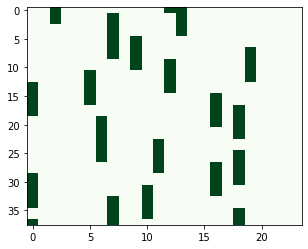

In [12]:
args_maximum =97.5
args_minimum=2.5

n_samples = (args_maximum - args_minimum) / enc.parameters.resolution
oversample = 2 # Use more samples than needed to avoid aliasing & artifacts.
n_samples  = int(round( oversample * n_samples ))

sdrs = []
for i in np.linspace(args_minimum, args_maximum, n_samples):
  sdrs.append( enc.encode( i ).dense )

#print(np.array(sdrs))

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(np.array(sdrs), cmap = "Greens", aspect=0.5)
plt.show()

### DateEncoder（日付エンコーダ）

日付エンコーダは、時刻と日付をエンコードします。 日付エンコーダへの入力は datetime.datetime オブジェクトです。

出力はいくつかのサブエンコーディングを連結したもので、それぞれが日付の異なる側面をエンコードしています。

どのサブエンコーディングが存在するか、そしてそれらのサブエンコーディングの詳細は DateEncoder のコンストラクタで指定します。

In [13]:
import datetime
from htm.encoders.date import DateEncoder

**コンストラクタ**

- season ：季節の幅を表現します。デフォルトの1シーズン=91.5日です。
- dayOfWeek ：平日の日数を表現します。デフォルトは1日です。
- weekend ：週末かどうか。0または1のビットで表現します。 （注意）実装では、金曜日の午後6時から日曜日の午前0時まで。
- holiday ：休日かどうか。0または1のビットで表現します。
- timeOfday ：一日の時間を表現します。

In [14]:
dateEncoder = DateEncoder(season  = 4) 

now = datetime.datetime.strptime("2019-05-02 13:08:58", "%Y-%m-%d %H:%M:%S")
print ("now =       ", dateEncoder.encode(now))

nextMonth = datetime.datetime.strptime("2019-06-02 13:08:58", "%Y-%m-%d %H:%M:%S")
print ("next month =", dateEncoder.encode(nextMonth))

xmas = datetime.datetime.strptime("2019-12-25 13:08:58", "%Y-%m-%d %H:%M:%S")
print ("xmas =      ", dateEncoder.encode(xmas))

now =        SDR( 16 ) 5, 6, 7, 8
next month = SDR( 16 ) 7, 8, 9, 10
xmas =       SDR( 16 ) 0, 1, 2, 3


In [15]:
print ("now =       ", dateEncoder.encode(now).dense)
print ("next month =", dateEncoder.encode(nextMonth).dense)
print ("xmas =      ", dateEncoder.encode(xmas).dense)

now =        [0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]
next month = [0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0]
xmas =       [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
dateEncoder = DateEncoder(dayOfWeek  = 5, weekend=2, timeOfDay=4) 

now = datetime.datetime.strptime("2019-05-02 13:08:58", "%Y-%m-%d %H:%M:%S")
print ("now =       ", dateEncoder.encode(now))

nextMonth = datetime.datetime.strptime("2019-06-02 13:08:58", "%Y-%m-%d %H:%M:%S")
print ("next month =", dateEncoder.encode(nextMonth))

xmas = datetime.datetime.strptime("2019-12-25 13:08:58", "%Y-%m-%d %H:%M:%S")
print ("xmas =      ", dateEncoder.encode(xmas))

now =        SDR( 63 ) 15, 16, 17, 18, 19, 35, 36, 52, 53, 54, 55
next month = SDR( 63 ) 30, 31, 32, 33, 34, 37, 38, 52, 53, 54, 55
xmas =       SDR( 63 ) 10, 11, 12, 13, 14, 35, 36, 52, 53, 54, 55


In [17]:
print ("now =       ", dateEncoder.encode(now).dense)
print ("next month =", dateEncoder.encode(nextMonth).dense)
print ("xmas =      ", dateEncoder.encode(xmas).dense)

now =        [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]
next month = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]
xmas =       [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]]


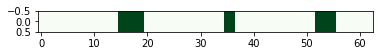

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

sampleSDR=np.reshape(dateEncoder.encode(now).dense,(1,dateEncoder.encode(now).dense.shape[0]))
print(sampleSDR)

plt.imshow(sampleSDR, cmap = "Greens", aspect=4)
plt.show()

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]]


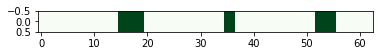

[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]]


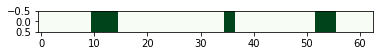

[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]]


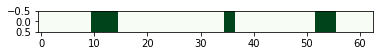

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

nowSDR = dateEncoder.encode(now)
sampleSDR = nowSDR.dense.reshape(1,nowSDR.dense.shape[0])

print(sampleSDR)

plt.imshow(sampleSDR, cmap = "Greens", aspect=4)
plt.show()

nextMonthSDR = dateEncoder.encode(xmas)
sampleSDR = nextMonthSDR.dense.reshape(1,nextMonthSDR.dense.shape[0])

print(sampleSDR)

plt.imshow(sampleSDR, cmap = "Greens", aspect=4)
plt.show()

xmasSDR = dateEncoder.encode(xmas)
sampleSDR = xmasSDR.dense.reshape(1,xmasSDR.dense.shape[0])

print(sampleSDR)

plt.imshow(sampleSDR, cmap = "Greens", aspect=4)
plt.show()

### CategoryEncoders（カテゴリエンコーダー）

入力のカテゴリをエンコードするには、ScalarEncoderまたはRandom Distributed Scalar Encoder (RDSE)を作成し、パラメータ category=True を設定します。 

そして、エンコードする前にカテゴリを整数に列挙します。

In [24]:
from htm.bindings.encoders import ScalarEncoder, ScalarEncoderParameters
from htm.bindings.sdr import SDR
import numpy as np

**パラメータ**
- ```category``` – 離散的な文字列カテゴリのリスト

In [25]:
categories = ("unknown","cat", "dog", "monkey", "slow loris")

scalarEncoderParams = ScalarEncoderParameters()
scalarEncoderParams.minimum = 0
scalarEncoderParams.maximum = 5
scalarEncoderParams.activeBits = 3
scalarEncoderParams.category = True

enc = ScalarEncoder(scalarEncoderParams)

print ("cat =       ", enc.encode(1))
print ("dog =       ", enc.encode(2))
print ("monkey =    ", enc.encode(3))
print ("slow loris =", enc.encode(4))

cat =        SDR( 18 ) 3, 4, 5
dog =        SDR( 18 ) 6, 7, 8
monkey =     SDR( 18 ) 9, 10, 11
slow loris = SDR( 18 ) 12, 13, 14


In [26]:
print ("cat =       ", enc.encode(1).dense)
print ("dog =       ", enc.encode(2).dense)
print ("monkey =    ", enc.encode(3).dense)
print ("slow loris =", enc.encode(4).dense)

cat =        [0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
dog =        [0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
monkey =     [0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
slow loris = [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]


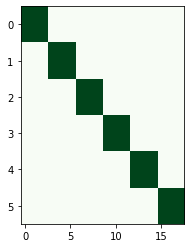

In [27]:
n_samples = int(enc.parameters.maximum - enc.parameters.minimum + 1)

sdrs = []
for i in np.linspace(enc.parameters.minimum, enc.parameters.maximum, n_samples):
  sdrs.append( enc.encode( i ).dense )

#print(np.array(sdrs))

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(np.array(sdrs), cmap = "Greens")
plt.show()

In [12]:
print (enc.encode(categories.index("unknown")+1))

SDR( 15 ) 0, 1, 2


In [13]:
print (enc.decode(categories.index("cat")+1))

AttributeError: 'htm.bindings.encoders.ScalarEncoder' object has no attribute 'decode'

In [14]:
catdog = numpy.array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0])
print (enc.decode(catdog))

NameError: name 'numpy' is not defined